In [2]:
!pip install strawberryfields --upgrade


  Using cached StrawberryFields-0.23.0-py3-none-any.whl.metadata (7.6 kB)
  Using cached numba-0.60.0-cp312-cp312-win_amd64.whl.metadata (2.8 kB)
  Using cached quantum_blackbird-0.5.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached thewalrus-0.21.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached quantum_xir-0.2.2-py3-none-any.whl.metadata (4.1 kB)
  Using cached xanadu_cloud_client-0.3.2-py3-none-any.whl.metadata (8.3 kB)
  Using cached antlr4_python3_runtime-4.9.2-py3-none-any.whl
  Using cached lark_parser-0.12.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached dask-2024.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached llvmlite-0.43.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached fire-0.7.0-py3-none-any.whl
  Using cached pydantic_settings-2.6.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.1.0-py3-none-any.w

In [3]:
import strawberryfields as sf

In [4]:
from strawberryfields.ops import *

In [6]:
# initialize engine and program objects
eng = sf.Engine(backend="gaussian")
gate_teleportation = sf.Program(4)

with gate_teleportation.context as q:
    # create initial states
    Squeezed(0.1) | q[0]
    Squeezed(-2)  | q[1]
    Squeezed(-2)  | q[2]

    # apply the gate to be teleported
    Pgate(0.5) | q[1]

    # conditional phase entanglement
    CZgate(1) | (q[0], q[1])
    CZgate(1) | (q[1], q[2])

    # projective measurement onto
    # the position quadrature
    Fourier.H | q[0]
    MeasureX | q[0]
    Fourier.H | q[1]
    MeasureX | q[1]
    # compare against the expected output
    # X(q1/sqrt(2)).F.P(0.5).X(q0/sqrt(0.5)).F.|z>
    # not including the corrections
    Squeezed(0.1)   | q[3]
    Fourier         | q[3]
    Xgate(q[0].par) | q[3]
    Pgate(0.5)      | q[3]
    Fourier         | q[3]
    Xgate(q[1].par) | q[3]
    # end circuit

results = eng.run(gate_teleportation)
print(results.state.reduced_gaussian([2]))
print(results.state.reduced_gaussian([3]))


(array([-3.39419291,  6.79924061]), array([[ 1.11257261, -0.5851662 ],
       [-0.5851662 ,  1.20659044]]))
(array([-3.54135494,  6.98920789]), array([[ 1.12408144, -0.61070138],
       [-0.61070138,  1.22140276]]))


In [11]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

# set the random seed
np.random.seed(42)

In [12]:
prog = sf.Program(3)

In [13]:
alpha = 1+0.5j
r = np.abs(alpha)
phi = np.angle(alpha)

with prog.context as q:
    # prepare initial states
    Coherent(r, phi) | q[0]
    Squeezed(-2) | q[1]
    Squeezed(2) | q[2]

    # apply gates
    BS = BSgate(pi/4, pi)
    BS | (q[1], q[2])
    BS | (q[0], q[1])

    # Perform homodyne measurements
    MeasureX | q[0]
    MeasureP | q[1]

    # Displacement gates conditioned on
    # the measurements
    Xgate(sqrt(2) * q[0].par) | q[2]
    Zgate(-sqrt(2) * q[1].par) | q[2]

In [14]:
sf.Engine(backend, backend_options={})

NameError: name 'backend' is not defined

In [15]:
eng = sf.Engine('fock', backend_options={"cutoff_dim": 15})

In [16]:
result = eng.run(prog, shots=1, modes=None, compile_options={})

In [17]:
print(result.samples)

[[0.19890199 0.17330173]]


In [18]:
print(result.state)
state = result.state

<FockState: num_modes=3, cutoff=15, pure=False, hbar=2>


In [19]:
print(state.dm().shape)

(15, 15, 15, 15, 15, 15)


In [20]:
rho2 = np.einsum('kkllij->ij', state.dm())
print(rho2.shape)

(15, 15)


In [21]:
probs = np.real_if_close(np.diagonal(rho2))
print(probs)

[3.10694907e-01 3.62467630e-01 2.11807608e-01 8.23802050e-02
 2.43874177e-02 5.83556629e-03 1.26776314e-03 2.37656289e-04
 8.43934922e-05 1.78787082e-06 1.52342119e-04 1.07036413e-05
 3.36055927e-04 1.47426072e-05 1.92773805e-04]


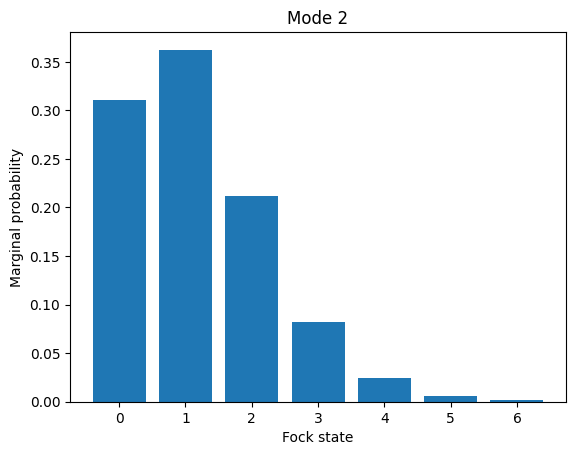

In [22]:
from matplotlib import pyplot as plt
plt.bar(range(7), probs[:7])
plt.xlabel('Fock state')
plt.ylabel('Marginal probability')
plt.title('Mode 2')
plt.show()

In [23]:
fock_probs = state.all_fock_probs()
fock_probs.shape
np.sum(fock_probs, axis=(0,1))

array([3.10694907e-01, 3.62467630e-01, 2.11807608e-01, 8.23802050e-02,
       2.43874177e-02, 5.83556629e-03, 1.26776314e-03, 2.37656289e-04,
       8.43934922e-05, 1.78787082e-06, 1.52342119e-04, 1.07036413e-05,
       3.36055927e-04, 1.47426072e-05, 1.92773805e-04])